### Implementing 

In [2]:
import cv2
import os
import uuid
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D,Input, InputLayer, Flatten,ReLU


2023-10-28 19:17:59.722915: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-28 19:17:59.757895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 19:18:00.221398: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 19:18:00.222730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 19:18:02.154359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
POS_PATH = os.path.join('Data','positive')
NEG_PATH = os.path.join('Data','negative')
ANK_PATH = os.path.join('Data','anchor')



In [51]:
# Make necessary folders
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANK_PATH)

FileExistsError: [Errno 17] File exists: 'Data/positive'

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [13]:
from mtcnn.mtcnn import MTCNN
from PIL import Image

D = MTCNN()

In [14]:
def f_getFace(I):
    r=D.detect_faces(I)
    x1,y1,w,h=r[0]['box']
    x2,y2=x1+w,y1+h
    face=I[y1:y2,x1:x2]
    return Image.fromarray(face).resize((250,250))

In [5]:
# namespace_uuid = uuid.UUID('6ba7b810-9dad-11d1-80b4-00c04fd430c8')
# name = '210101'
# uuid3 = uuid.uuid3(namespace_uuid, name)
# print(f'uuid3: {uuid3}')

In [35]:
import time

In [40]:
window_name = 'Face Attendance System'

cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    key = cv2.waitKey(1)
    
#     if cv2.waitKey(1) & 0XFF == ord('a'):
        
    
#     if key == ord('a'):
    cv2.imwrite('current.jpg', frame)
    P1=Image.open(r'current.jpg')

    f1 = f_getFace(np.asarray(P1))
    imgname = os.path.join(ANK_PATH, '{}.jpg'.format(uuid.uuid1()))
    imgS = cv2.cvtColor(np.asarray(f1), cv2.COLOR_BGR2RGB)
    cv2.imwrite(imgname, imgS)
    time.sleep(0.5)
    
        
    if key == ord('p'):
        cv2.imwrite('positive.jpg', frame)
        P1=Image.open(r'positive.jpg')

        f1 = f_getFace(np.asarray(P1))
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        imgS = cv2.cvtColor(np.asarray(f1), cv2.COLOR_BGR2RGB)
        cv2.imwrite(imgname, imgS)
        
        
        
       
    # Cut down frame to 250x250px
#     frame = frame[120:120+250,200:200+250, :]
    
#     # Collect anchors 
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path 
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)
    
#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path 
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out positive image
#         cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow(window_name, frame)
    

    if key == ord('q'):
        break
        
# Release the webcam
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 14ms/step


In [46]:
anchor = tf.data.Dataset.list_files(ANK_PATH+'/*.jpg').take(40)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(40)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(40)

In [17]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

### Labelled Datset

In [48]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [49]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [50]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=32)

In [51]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [52]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model

In [53]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 17, 17, 128)       26

# ------------------------------------------------------------------

In [63]:
inp = Input(shape=(100,100,3), name='input_image')

In [64]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [65]:
from tensorflow.keras import layers

In [66]:
model = tf.keras.Sequential([
    Conv2D(64, (10,10), input_shape=(100,100,3)),
    ReLU(),
    MaxPooling2D(64, (2,2), padding= 'same'),
    
    Conv2D(128, (7,7), activation='relu'),
    MaxPooling2D(64, (2,2), padding= 'same'),
    
    Conv2D(128, (4,4), activation='relu'),
    MaxPooling2D(64, (2,2), padding= 'same'),
    
    Conv2D(256, (4,4), activation='relu'),

    Flatten(),
    Dense(4096, activation='sigmoid')
])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 re_lu_1 (ReLU)              (None, 91, 91, 64)        0         
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 17, 17, 128)      

## Build Distance Layer

In [5]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [55]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


siamese_model = make_siamese_model()
siamese_model.summary()              

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [70]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [71]:
siamese_layer = L1Dist()
distances = siamese_layer(model(input_image), model(validation_image))
classifier = Dense(1, activation='sigmoid')(distances)

In [72]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_28')>

In [73]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [74]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 sequential_1 (Sequential)   (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [75]:
# def make_siamese_model(): 
    
#     # Anchor image input in the network
#     input_image = Input(name='input_img', shape=(100,100,3))
    
#     # Validation image in the network 
#     validation_image = Input(name='validation_img', shape=(100,100,3))
    
#     # Combine siamese distance components
#     siamese_layer = L1Dist()
#     siamese_layer._name = 'distance'
#     distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
#     # Classification layer 
#     classifier = Dense(1, activation='sigmoid')(distances)
    
#     return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

## Training

In [56]:
# model.compile(optimizer='adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [57]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [58]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [59]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
#         if epoch % 10 == 0: 
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [60]:
EPOCHS = 30
train(train_data, EPOCHS)


 Epoch 1/30
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
4/4 [==============================] - 5s 1s/step
0.6371424 0.85294116 0.9354839

 Epoch 2/30
4/4 [==============================] - 4s 946ms/step
0.5364865 0.5151515 1.0

 Epoch 3/30
4/4 [==============================] - 4s 914ms/step
0.19609436 0.79310346 1.0

 Epoch 4/30
4/4 [==============================] - 4s 940ms/step
0.26786473 0.82857144 1.0

 Epoch 5/30
4/4 [==============================] - 4s 963ms/step
0.058559023 1.0 1.0

 Epoch 6/30
4/4 [==============================] - 4s 962ms/step
0.08690322 1.0 1.0

 Epoch 7/30
4/4 [==============================] - 4s 975ms/step
0.062166996 1.0 1.0

 Epoch 8/30
4/4 [==============================] - 4s 967ms/step
0.071391866 1.0 1.0

 Epoch 9/30
4/4 [==============================] - 4s 991ms/step
0.013136028 1.0 1.0

 Epoch 10/30
4/4 [==============================

In [61]:
from tensorflow.keras.metrics import Precision, Recall

In [62]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 265ms/step


In [63]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]

In [64]:
y_true

array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

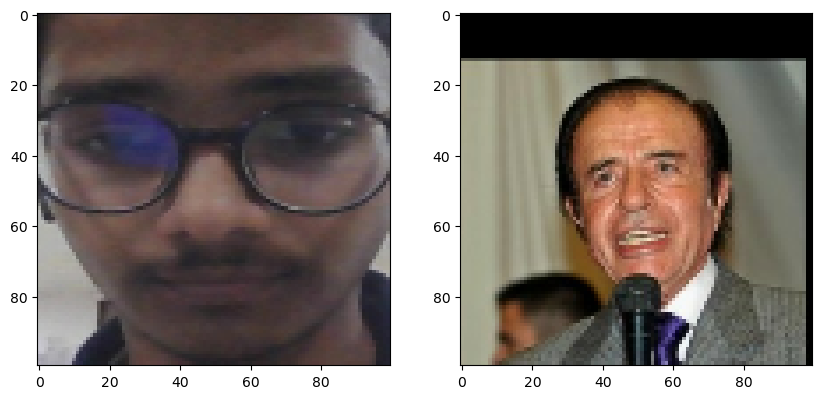

In [66]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Save Model

In [62]:
# r = Recall()
# p = Precision()

# for test_input, test_val, y_true in test_data.as_numpy_iterator():
#     yhat = siamese_model.predict([test_input, test_val])
#     r.update_state(y_true, yhat)
#     p.update_state(y_true,yhat) 

# print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 147ms/step
1.0 1.0


In [24]:
siamese_model.save('siamese_model.h5')

In [6]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamese_model.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [25]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 270ms/step


array([[1.0000000e+00],
       [2.3135042e-05],
       [1.3402749e-06],
       [9.9991906e-01],
       [2.5489453e-06],
       [3.8746108e-05],
       [5.3720460e-06],
       [9.9997240e-01],
       [6.2647439e-07],
       [9.9982178e-01],
       [1.7359543e-08],
       [2.2773693e-04],
       [1.0000000e+00],
       [1.3713661e-04],
       [2.4472251e-07],
       [3.3759555e-08]], dtype=float32)

In [32]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('Application_Data', 'verification_imgs')):
        input_img = preprocess(os.path.join('Application_Data', 'input_imgs', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('Application_Data', 'verification_imgs', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        print(result)
        if result> 0.85:
            return _,True
    return _,False
        #         print(result)
#         results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
#     detection = np.sum(np.array(results) > detection_threshold)
    
#     # Verification Threshold: Proportion of positive predictions / total positive samples 
#     verification = detection / len(os.listdir(os.path.join('Application_Data', 'verification_imgs'))) 
#     verified = verification > vqerification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite('positive.jpg', frame)
        P1=Image.open(r'positive.jpg')

        f1 = f_getFace(np.asarray(P1))
        imgname= os.path.join('Application_Data', 'input_imgs', 'input_image.jpg')
        imgS = cv2.cvtColor(np.asarray(f1), cv2.COLOR_BGR2RGB)
        cv2.imwrite(imgname, imgS)
        
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 39ms/step
[[0.4426716]]
1/1 [==============================] - 0s 40ms/step
[[0.7736401]]
1/1 [==============================] - 0s 40ms/step
[[0.47153485]]
1/1 [==============================] - 0s 42ms/step
[[0.95206994]]
True
1/1 [==============================] - 0s 37ms/step
[[0.25067812]]
1/1 [==============================] - 0s 43ms/step
[[0.59008294]]
1/1 [==============================] - 0s 40ms/step
[[0.6793287]]
1/1 [==============================] - 0s 41ms/step
[[0.893235]]
True
1/1 [==============================] - 0s 43ms/step
[[0.28177914]]
1/1 [==============================] - 0s 42ms/step
[[0.6280019]]
1/1 [==============================] - 0s 42ms/step
[[0.90750706]]
True
1/1 [==============================] - 0s 41ms/step
[[0.16389292]]
1/1 [==============================] - 0s 42ms/step
[[0.9060209]]
True
1/1 [==============================] - 0s 39ms/step
[[0.8911415]]
True
1/1 [==============================] - 0s 38m

In [25]:
cap.release()
cv2.destroyAllWindows()

In [20]:
np.sum(np.squeeze(results) > 0.5)/25

0.52

0.72